In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
import numpy as np
import random


In [2]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [3]:
transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)


Files already downloaded and verified


In [4]:
# 学習

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}")


Epoch [1/50], Loss: 0.002425
Epoch [2/50], Loss: 0.001176
Epoch [3/50], Loss: 0.000809
Epoch [4/50], Loss: 0.000917
Epoch [5/50], Loss: 0.000593
Epoch [6/50], Loss: 0.000592
Epoch [7/50], Loss: 0.000523
Epoch [8/50], Loss: 0.000449
Epoch [9/50], Loss: 0.000496
Epoch [10/50], Loss: 0.000408
Epoch [11/50], Loss: 0.000377
Epoch [12/50], Loss: 0.000402
Epoch [13/50], Loss: 0.000404
Epoch [14/50], Loss: 0.000358
Epoch [15/50], Loss: 0.000352
Epoch [16/50], Loss: 0.000367
Epoch [17/50], Loss: 0.000325
Epoch [18/50], Loss: 0.000346
Epoch [19/50], Loss: 0.000295
Epoch [20/50], Loss: 0.000307
Epoch [21/50], Loss: 0.000309
Epoch [22/50], Loss: 0.000259
Epoch [23/50], Loss: 0.000324
Epoch [24/50], Loss: 0.000298
Epoch [25/50], Loss: 0.000298
Epoch [26/50], Loss: 0.000272
Epoch [27/50], Loss: 0.000276
Epoch [28/50], Loss: 0.000297
Epoch [29/50], Loss: 0.000269
Epoch [30/50], Loss: 0.000253
Epoch [31/50], Loss: 0.000240
Epoch [32/50], Loss: 0.000235
Epoch [33/50], Loss: 0.000305
Epoch [34/50], Loss

In [5]:
sample_indices = random.sample(range(len(trainset)), 100)
samples = [trainset[i][0] for i in sample_indices]
sample_tensors = torch.stack(samples).to(device)
encoded_samples = model.encoder(sample_tensors)
bottleneck_features = encoded_samples.view(encoded_samples.size(0), -1).detach().cpu().numpy()


/home/yanai-lab/tanabe-h/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



クラスタリング結果 (k=5):
Cluster 0:


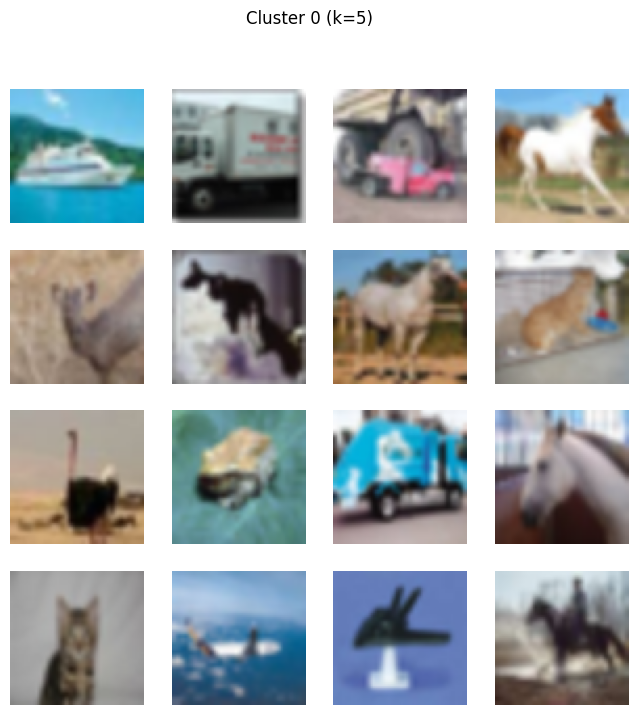

Cluster 1:


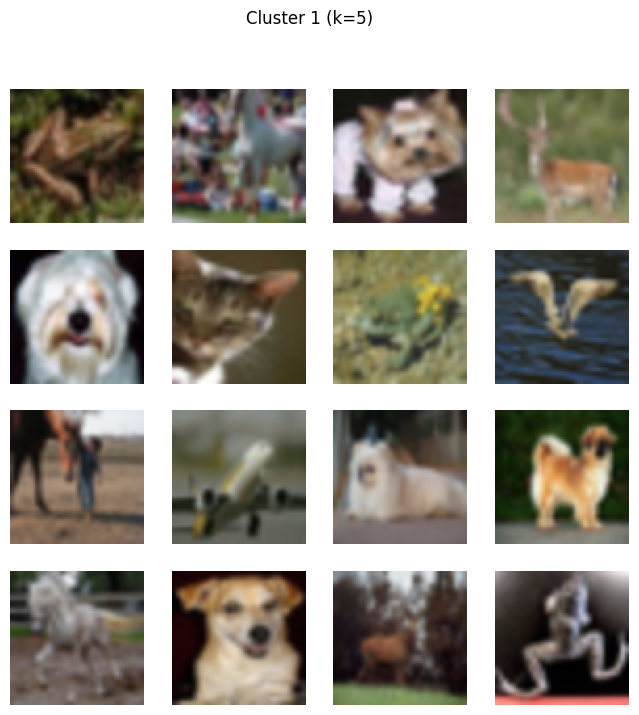

Cluster 2:


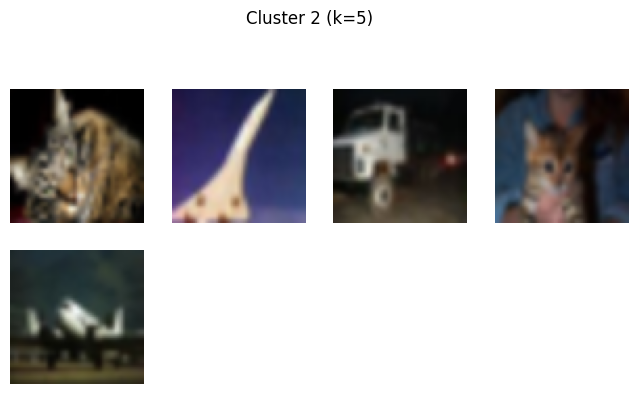

Cluster 3:


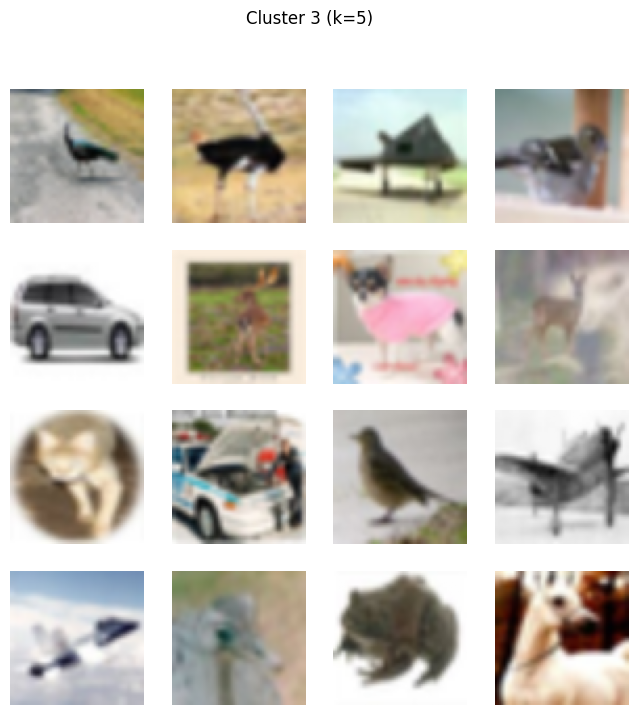

Cluster 4:


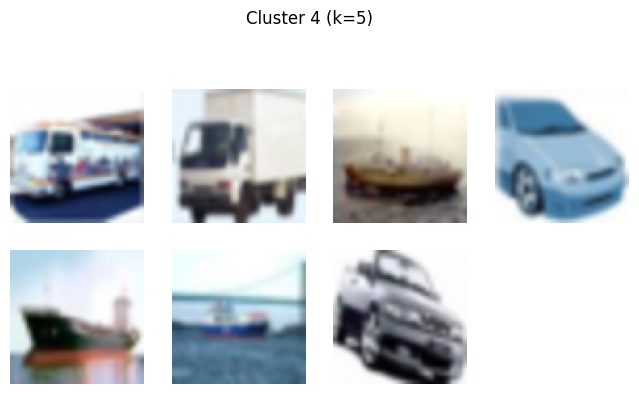

/home/yanai-lab/tanabe-h/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



クラスタリング結果 (k=10):
Cluster 0:


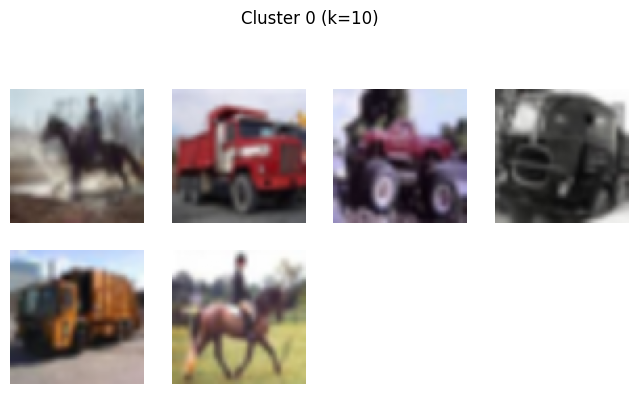

Cluster 1:


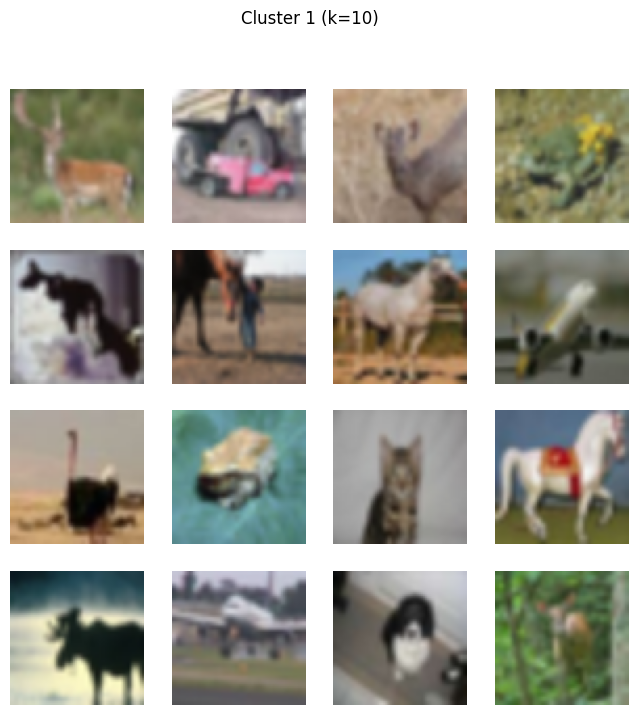

Cluster 2:


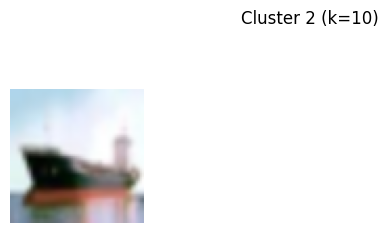

Cluster 3:


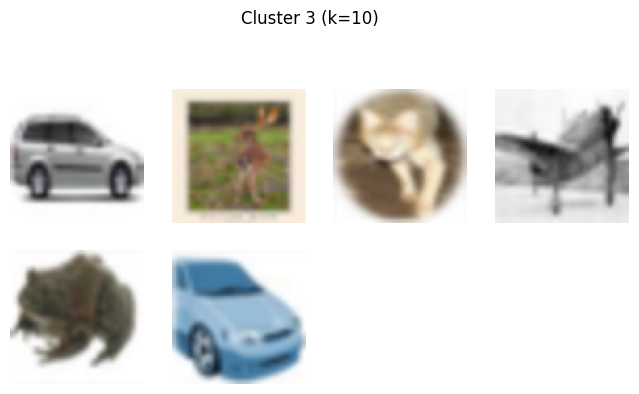

Cluster 4:


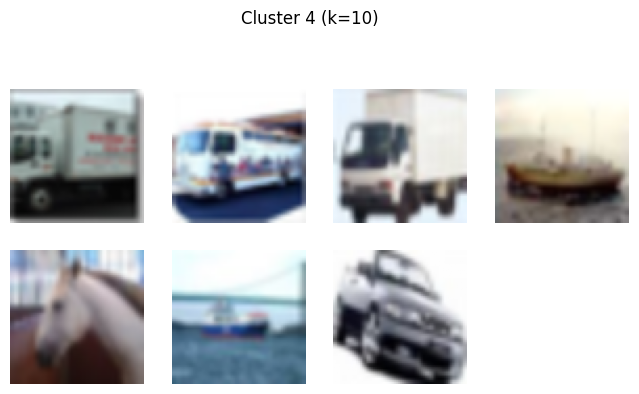

Cluster 5:


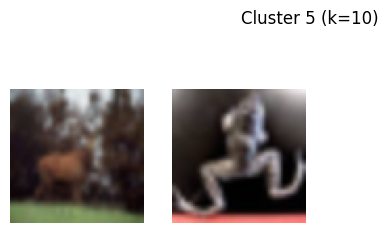

Cluster 6:


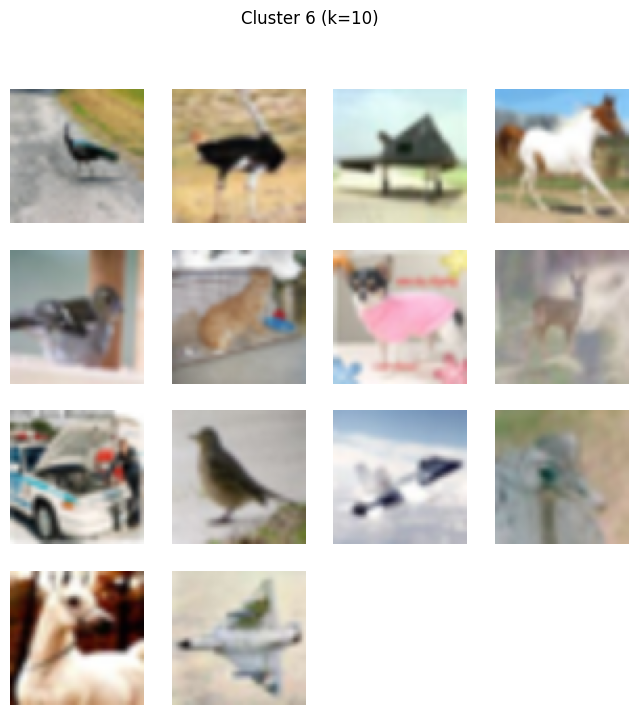

Cluster 7:


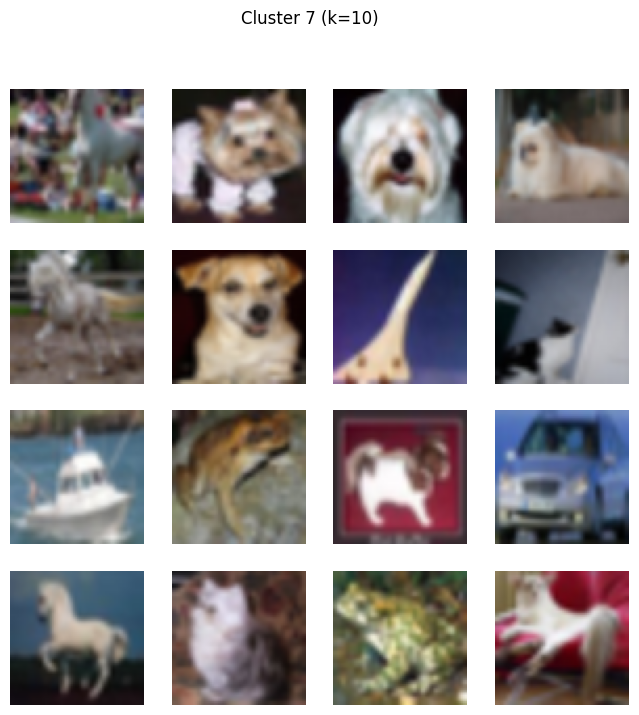

Cluster 8:


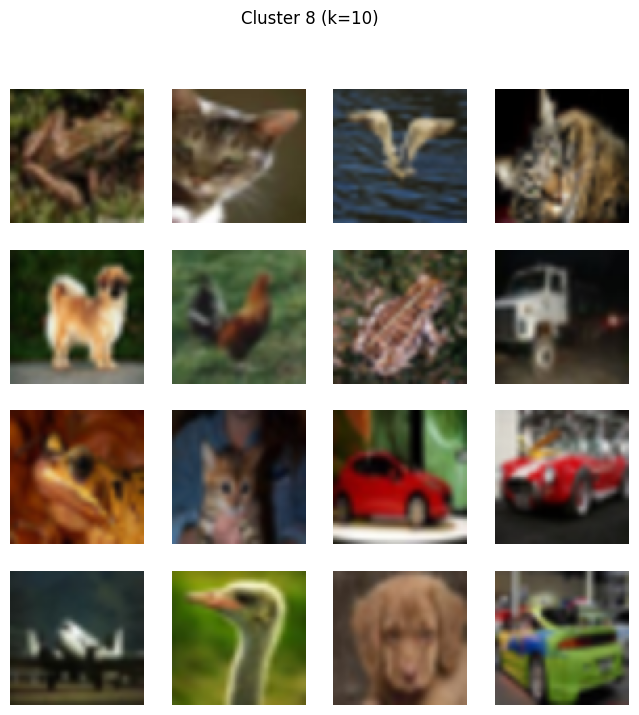

Cluster 9:


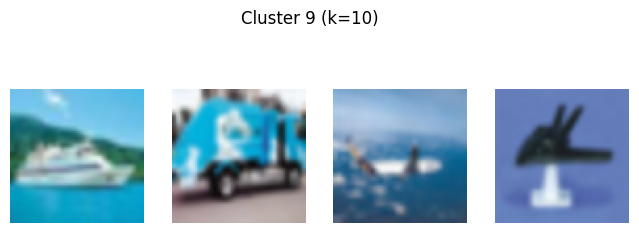

In [6]:
import matplotlib.pyplot as plt

def display_images(images, title, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].permute(1, 2, 0))
            ax.axis("off")
        else:
            ax.remove()
    plt.suptitle(title)
    plt.show()

for k in [5, 10]:
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(bottleneck_features)
    print(f"\nクラスタリング結果 (k={k}):")
    for i in range(k):
        print(f"Cluster {i}:")
        cluster_members = np.where(cluster_labels == i)[0]
        cluster_images = [samples[member_index] for member_index in cluster_members]
        display_images(cluster_images, f"Cluster {i} (k={k})", 4, 4)
